# EEG to Predict Eye State Dataset

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

## Data preparation and preprocessing

In [2]:
column_names=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7',
             'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 
              'F8', 'AF4', 'eyeDetection']
EEG_df = pd.read_csv('EEG Eye State', names=column_names, 
             sep=',', na_values='?', skipinitialspace=True) # Load dataset to DataFrame object

print(EEG_df)


           AF3       F7       F3      FC5       T7       P7       O1       O2  \
0      4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1      4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2      4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3      4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4      4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14975  4281.03  3990.26  4245.64  4116.92  4333.85  4614.36  4074.87  4625.64   
14976  4276.92  3991.79  4245.13  4110.77  4332.82  4615.38  4073.33  4621.54   
14977  4277.44  3990.77  4246.67  4113.85  4333.33  4615.38  4072.82  4623.59   
14978  4284.62  3991.79  4251.28  4122.05  4334.36  4616.41  4080.51  4628.72   
14979  4287.69  3997.44  4260.00  4121.03  4333.33  4616.41  4088.72  4638.46   

            P8       T8    

All data is numerical, let's see if we have any missing values.

In [3]:
EEG_df.isna().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

Now, let's split into X and Y. The default values for the labels ('eyeDetection') is 0 and 1, so I also want to map 0 to -1. Also, because many of the features (columns) have different value ranges, I want to normalize the columns so as to avoid some features to more heavily influence my models.

In [4]:
# X 
X_df = EEG_df.drop('eyeDetection', axis=1, inplace=False) # Make DataFrame object without labels
X = X_df.values # Shape (14980, 14)
min_max_scaler = preprocessing.MinMaxScaler() 
X = min_max_scaler.fit_transform(X) # Normalize X
print(X.shape)

# Y
EEG_df['eyeDetection'] = EEG_df['eyeDetection'].map({ 0: -1, 1: 1})
Y = EEG_df.values[:,-1] # Shape (14980,)
Y = Y.astype('int')
print(Y.shape)
print(Y)


(14980, 14)
(14980,)
[-1 -1 -1 ...  1  1  1]


Let's check how many positives we have. (For display purposes)

In [12]:
pos_count = len(list(filter(lambda x: (x >= 0), Y)))
print(pos_count)
print(pos_count/len(Y))

6723
0.4487983978638184


## Main algorithm

In [5]:
partitions=[0.2, 0.8]
C_list = [0.1, 1, 10, 100, 1000]
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_estimators = [25, 50, 100]
max_depth = [1, 5, 10]
svm_accuracy=[]
knn_accuracy=[]
random_forest_accuracy=[]

for p in partitions:
    for t in range (3):
        print('-----------------------------------')
        print('\nPartition (% training): ' + str(p*100))
        print('Trial number '+ str(t+1)+'/3')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=p, random_state=t+1)

        #Linear SVM
        print('\nLinear SVM')
        
        # Cross validate
        estimator = svm.LinearSVC(penalty='l2', loss='hinge', random_state=1024)
        param_grid = {'C': C_list}
        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10)
        grid_search.fit(X_train, Y_train)
        svm_cross_val_results = grid_search.cv_results_
        
        # Train using best hyperperamater(s)
        C = grid_search.best_params_['C']
        classifier = svm.LinearSVC(penalty='l2', loss='hinge', C=C, random_state=1024)
        classifier.fit(X_train, Y_train)
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred = classifier.predict(X_test)
        
        svm_accuracy.append(accuracy_score(Y_train, Y_train_pred))
        svm_accuracy.append(accuracy_score(Y_test, Y_test_pred))
        
        print('Best parameter, C: '+ str(C))
        print(svm_accuracy)
        
        #k-NN
        print('\nk-NN')
        
        # Cross validate
        estimator = neighbors.KNeighborsClassifier()
        param_grid = {'n_neighbors': k_list}
        grid_search = GridSearchCV(estimator, param_grid, cv=5)
        grid_search.fit(X_train, Y_train)
        knn_cross_val_results = grid_search.cv_results_
        
        # Train using best hyperperamater(s)
        k = grid_search.best_params_['n_neighbors']
        classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, Y_train)
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred = classifier.predict(X_test)
        
        knn_accuracy.append(accuracy_score(Y_train, Y_train_pred))
        knn_accuracy.append(accuracy_score(Y_test, Y_test_pred))
        
        print('Best parameter, k: '+str(k))
        print(knn_accuracy)
        
        #Random forest
        print('\nRandom forest')
        
        # Cross validate
        estimator = ensemble.RandomForestClassifier(random_state=1024)
        param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
        grid_search = GridSearchCV(estimator, param_grid, cv=5)
        grid_search.fit(X_train, Y_train)
        forest_cross_val_results = grid_search.cv_results_
        
        # Train using best hyperperamater(s)
        n = grid_search.best_params_['n_estimators']
        d = grid_search.best_params_['max_depth']
        classifier = ensemble.RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1024)
        classifier.fit(X_train, Y_train)
        
        # Obtain the training and testing accuracy
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred = classifier.predict(X_test)
        
        random_forest_accuracy.append(accuracy_score(Y_train, Y_train_pred))
        random_forest_accuracy.append(accuracy_score(Y_test, Y_test_pred))
        print('Best parameter, n_estimators: '+str(n))
        print('Best parameter, max_depth: '+str(d))
        print(random_forest_accuracy)
        

-----------------------------------

Partition (% training): 20.0
Trial number 1/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.5597463284379173, 0.5489819759679573]

k-NN
Best parameter, k: 1
[1.0, 0.7610981308411215]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.9529372496662216, 0.8341121495327103]
-----------------------------------

Partition (% training): 20.0
Trial number 2/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.5597463284379173, 0.5489819759679573, 0.5463951935914553, 0.5642523364485982]

k-NN
Best parameter, k: 3
[1.0, 0.7610981308411215, 0.8918558077436582, 0.7580106809078772]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.9529372496662216, 0.8341121495327103, 0.9539385847797063, 0.8436248331108144]
-----------------------------------

Partition (% training): 20.0
Trial number 3/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.5597463284379173, 0.5489819759679573, 0.5463951935914553, 0.5642523364485982, 0.5477303070761015, 0.5555740987983978]

k-NN
Best parameter, k: 3
[1.0, 0.7610981308411215, 0.8918558077436582, 0.7580106809078772, 0.8925233644859814, 0.765520694259012]

Random forest
Best parameter, n_estimators: 50
Best parameter, max_depth: 10
[0.9529372496662216, 0.8341121495327103, 0.9539385847797063, 0.8436248331108144, 0.9619492656875834, 0.8432076101468625]
-----------------------------------

Partition (% training): 80.0
Trial number 1/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.5597463284379173, 0.5489819759679573, 0.5463951935914553, 0.5642523364485982, 0.5477303070761015, 0.5555740987983978, 0.5810246995994659, 0.5901201602136181]

k-NN
Best parameter, k: 3
[1.0, 0.7610981308411215, 0.8918558077436582, 0.7580106809078772, 0.8925233644859814, 0.765520694259012, 0.9213117489986649, 0.8314419225634179]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.9529372496662216, 0.8341121495327103, 0.9539385847797063, 0.8436248331108144, 0.9619492656875834, 0.8432076101468625, 0.9143858477970628, 0.8681575433911882]
-----------------------------------

Partition (% training): 80.0
Trial number 2/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.5597463284379173, 0.5489819759679573, 0.5463951935914553, 0.5642523364485982, 0.5477303070761015, 0.5555740987983978, 0.5810246995994659, 0.5901201602136181, 0.5798564753004005, 0.5864485981308412]

k-NN
Best parameter, k: 3
[1.0, 0.7610981308411215, 0.8918558077436582, 0.7580106809078772, 0.8925233644859814, 0.765520694259012, 0.9213117489986649, 0.8314419225634179, 0.9188918558077437, 0.8187583444592791]

Random forest
Best parameter, n_estimators: 50
Best parameter, max_depth: 10
[0.9529372496662216, 0.8341121495327103, 0.9539385847797063, 0.8436248331108144, 0.9619492656875834, 0.8432076101468625, 0.9143858477970628, 0.8681575433911882, 0.9097963951935915, 0.849799732977303]
-----------------------------------

Partition (% training): 80.0
Trial number 3/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.5597463284379173, 0.5489819759679573, 0.5463951935914553, 0.5642523364485982, 0.5477303070761015, 0.5555740987983978, 0.5810246995994659, 0.5901201602136181, 0.5798564753004005, 0.5864485981308412, 0.5825267022696929, 0.5844459279038718]

k-NN
Best parameter, k: 5
[1.0, 0.7610981308411215, 0.8918558077436582, 0.7580106809078772, 0.8925233644859814, 0.765520694259012, 0.9213117489986649, 0.8314419225634179, 0.9188918558077437, 0.8187583444592791, 0.8949432576769025, 0.8344459279038718]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.9529372496662216, 0.8341121495327103, 0.9539385847797063, 0.8436248331108144, 0.9619492656875834, 0.8432076101468625, 0.9143858477970628, 0.8681575433911882, 0.9097963951935915, 0.849799732977303, 0.9117990654205608, 0.8661548731642189]


### Averaged accuracy
Here I will find the averaged training and testing accuracy with standard deviation for each classifier out of the three trials in each partition.

In [6]:
# Function takes in the list of all accuracies and computes average accordingly + standard deviation
# Format of input: [(Partition1/Trial1/Training), (Partition1/Trial1/Testing), ...,
#                   (Partition2/Trial3/Training), (Partition2/Trial3/Testing)]
def averaged_accuracy(l):
    avg_train_20_l=[]
    avg_test_20_l=[]
    avg_train_80_l=[]
    avg_test_80_l=[]
    for i in range(len(l)):
        if i<6:
            if i%2==0:
                avg_train_20_l.append(l[i])
            else:
                avg_test_20_l.append(l[i])
        else:
            if i%2==0:
                avg_train_80_l.append(l[i])
            else:
                avg_test_80_l.append(l[i])

    avg_train_20 = sum(avg_train_20_l)/3
    avg_train_20_std = np.std(avg_train_20_l)
    avg_test_20 = sum(avg_test_20_l)/3
    avg_test_20_std = np.std(avg_test_20_l)
    avg_train_80 = sum(avg_train_80_l)/3
    avg_train_80_std = np.std(avg_train_80_l)
    avg_test_80 = sum(avg_test_80_l)/3
    avg_test_80_std = np.std(avg_test_80_l)
    return [(avg_train_20, avg_test_20, avg_train_20_std, avg_test_20_std),
            (avg_train_80, avg_test_80, avg_train_80_std, avg_test_80_std )]

In [7]:
#SVM
svm_avg_acc = averaged_accuracy(svm_accuracy)
print('SVM')
print('Average accuracy training 20/80: {} +/- {}'.format(svm_avg_acc[0][0], 
                                                          svm_avg_acc[0][2]))
print('Average accuracy testing 20/80: {} +/- {}'.format(svm_avg_acc[0][1],
                                                         svm_avg_acc[0][3]))
print('Average accuracy training 80/20: {} +/- {}'.format(svm_avg_acc[1][0],
                                                          svm_avg_acc[1][2]))
print('Average accuracy testing 80/20: {} +/- {}'.format(svm_avg_acc[1][1],
                                                         svm_avg_acc[1][3]))

#k-NN
knn_avg_acc = averaged_accuracy(knn_accuracy)
print('\nk-NN')
print('Average accuracy training 20/80: {} +/- {}'.format(knn_avg_acc[0][0], 
                                                          knn_avg_acc[0][2]))
print('Average accuracy testing 20/80: {} +/- {}'.format(knn_avg_acc[0][1],
                                                         knn_avg_acc[0][3]))
print('Average accuracy training 80/20: {} +/- {}'.format(knn_avg_acc[1][0],
                                                          knn_avg_acc[1][2]))
print('Average accuracy testing 80/20: {} +/- {}'.format(knn_avg_acc[1][1],
                                                         knn_avg_acc[1][3]))

#Random forest
forest_avg_acc = averaged_accuracy(random_forest_accuracy)
print('\nRandom forest')
print('Average accuracy training 20/80: {} +/- {}'.format(forest_avg_acc[0][0], 
                                                          forest_avg_acc[0][2]))
print('Average accuracy testing 20/80: {} +/- {}'.format(forest_avg_acc[0][1],
                                                         forest_avg_acc[0][3]))
print('Average accuracy training 80/20: {} +/- {}'.format(forest_avg_acc[1][0],
                                                          forest_avg_acc[1][2]))
print('Average accuracy testing 80/20: {} +/- {}'.format(forest_avg_acc[1][1],
                                                         forest_avg_acc[1][3]))
    

SVM
Average accuracy training 20/80: 0.5512906097018248 +/- 0.006003888546164703
Average accuracy testing 20/80: 0.5562694704049845 +/- 0.006253459498848882
Average accuracy training 80/20: 0.5811359590565198 +/- 0.0010929507512454813
Average accuracy testing 80/20: 0.5870048954161103 +/- 0.0023496564399135165

k-NN
Average accuracy training 20/80: 0.9281263907432132 +/- 0.05082304719120389
Average accuracy testing 20/80: 0.7615431686693369 +/- 0.0030820576606073883
Average accuracy training 80/20: 0.9117156208277702 +/- 0.011900926995051225
Average accuracy testing 80/20: 0.8282153983088563 +/- 0.006798672059391251

Random forest
Average accuracy training 20/80: 0.9562750333778371 +/- 0.004033059403736502
Average accuracy testing 20/80: 0.8403148642634624 +/- 0.004389287814192569
Average accuracy training 80/20: 0.911993769470405 +/- 0.0018786876714250531
Average accuracy testing 80/20: 0.8613707165109035 +/- 0.008222668543347515


### Draw heatmap
Heatmap showing cross validation accuracy for each combination of hyperparameters for the third trial on 80/20 split for each classifier.

#### SVM

Best parameter, C: 100


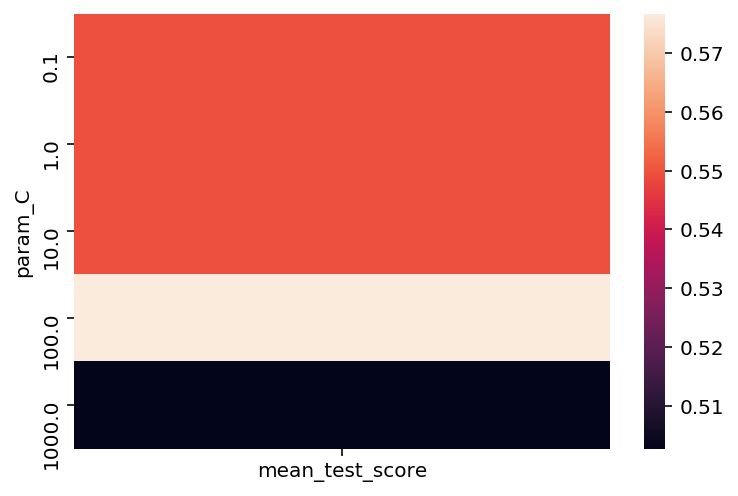

In [8]:
# SVM, trial 3, partion 80/20
pvt_forest = pd.pivot_table(pd.DataFrame(svm_cross_val_results),
    values='mean_test_score', index='param_C')
sns.heatmap(pvt_forest)
print("Best parameter, C: {}".format(C))

#### k-NN

Best parameter, n neighbors (k): 5


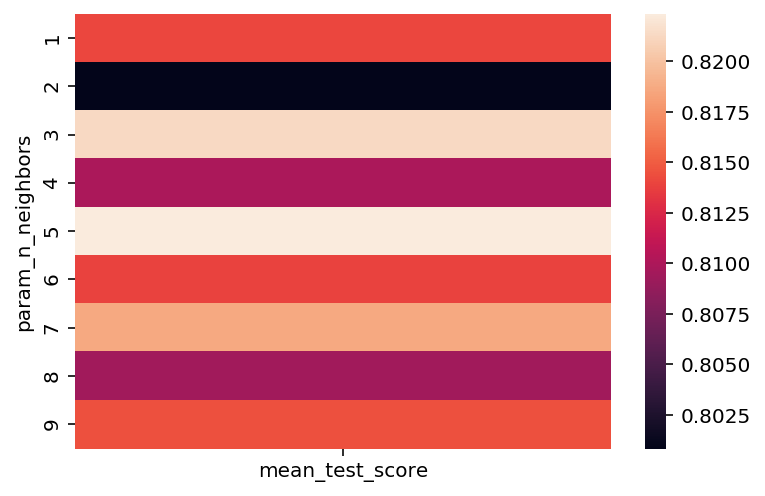

In [9]:
# k-NN, trial 3, partion 80/20
pvt_forest = pd.pivot_table(pd.DataFrame(knn_cross_val_results),
    values='mean_test_score', index='param_n_neighbors')
sns.heatmap(pvt_forest)
print("Best parameter, n neighbors (k): {}".format(k))

#### Random forest

Best parameter, n_estimators: 100
Best parameter, max_depth: 10


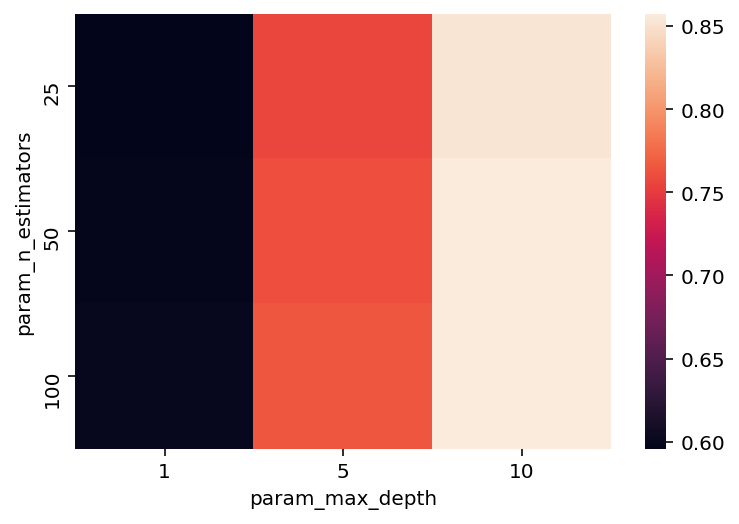

In [10]:
# Random forest, trial 3, partion 80/20
pvt_forest = pd.pivot_table(pd.DataFrame(forest_cross_val_results),
    values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
sns.heatmap(pvt_forest)
print("Best parameter, n_estimators: {}".format(n))
print("Best parameter, max_depth: {}".format(d))
